In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.signal import find_peaks
from lmfit.models import GaussianModel
from lmfit.models import ExponentialGaussianModel
from scipy.interpolate import UnivariateSpline

In [2]:
h = h5py.File('mod.hdf', 'r') 
index = h['Index']
amp = h['Amplitude']
am = []
for i in range(len(index) - 1):
    amp_ = amp[index[i]:index[i+1]]
    amp_ = amp_[amp_[:, 1]==0][:, 0]
    am.append(amp_)

In [3]:
amp = np.array(am[:100])
del(am)

In [4]:
amp.shape

(100,)

In [6]:
rsdl = []
pik = []
BICg = []
result_evl = []
for i in range(len(amp)):
    b = amp[i] - amp[i][:3].mean()
    x = np.arange(len(b))
    initial_peak_x = x[np.argmax(b)]
    initial_peak_y = b[np.argmax(b)]
    gmodel = GaussianModel()
    result = gmodel.fit(b, x=x, amplitude=int(initial_peak_y), center=int(initial_peak_x))
    time = np.arange(len(result.eval()))
    rsdl.append(result.residual)
    peak = np.argmax(result.eval())
    pik.append(peak)
    BICg.append(result.bic)
    result_evl.append(result.eval())

In [8]:
mx = 0
for i in range(len(rsdl)):
    if len(rsdl[i]) > mx:
        mx = len(rsdl[i])

In [9]:
mx

56

In [10]:
nan = np.empty((len(rsdl), mx + (max(pik) - min(pik)) * 4))
nan[:] = np.nan
for i in range(len(rsdl)):
    if i == 0:
        nan[i, :][((max(pik) - min(pik)) * 2) : ((max(pik) - min(pik)) * 2 + len(rsdl[i]))] = rsdl[i]
        idx = pik[i] + (max(pik) - min(pik)) * 2
    else:
        pkf = abs(len(rsdl[i][:pik[i]]) - len(nan[i, :][:idx]))
        pkl = - abs(len(rsdl[i][pik[i]:]) - len(nan[i, :][idx:]))
        nan[i, :][pkf:idx] = rsdl[i][:pik[i]]
        nan[i, :][idx:pkl] = rsdl[i][pik[i]:]

In [11]:
nan.shape

(498987, 92)

In [12]:
mean = []
std = []
median = []
for i in range(nan.shape[1]):
    mn = np.nanmean(nan[:, i])
    st = np.nanstd(nan[:, i])
    md = np.nanmedian(nan[:, i])
    mean.append(mn), std.append(st), median.append(md)
mean = np.array(mean)
median = np.array(median)
std = np.array(std)
pkvl = std[idx]
mean = mean[~np.isnan(mean)]
median = median[~np.isnan(median)]
std = std[~np.isnan(std)]
idx_new = np.where(std == pkvl)[0][0]

/home/shaig93/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/shaig93/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/shaig93/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


In [13]:
len(std), len(median), len(mean), nan.shape

(58, 58, 58, (498987, 92))

Text(0.5, 1.0, 'Mean, STD, Median of Residual (Gaussian fit)')

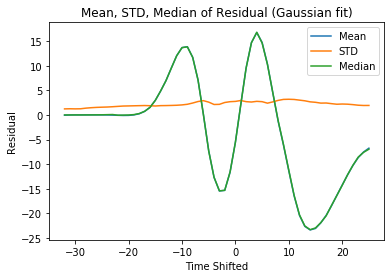

In [21]:
time = np.arange(len(mean))
plt.plot(time - idx_new, mean, label = 'Mean')
plt.plot(time - idx_new, std, label = 'STD')
plt.plot(time - idx_new, median, label = 'Median')
plt.xlabel('Time Shifted')
plt.ylabel('Residual')
plt.legend()
plt.title('Mean, STD, Median of Residual (Gaussian fit)')

Text(0, 0.5, 'Intensity')

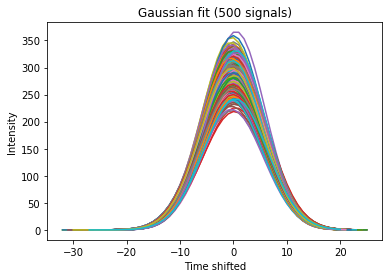

In [20]:
for i in range(500):
    time = np.arange(len(result_evl[:500][i]))
    plt.plot(time - np.argmax(result_evl[:500][i]), result_evl[:500][i])
plt.title('Gaussian fit (500 signals)')
plt.xlabel('Time shifted')
plt.ylabel('Intensity')

Text(0, 0.5, 'BIC')

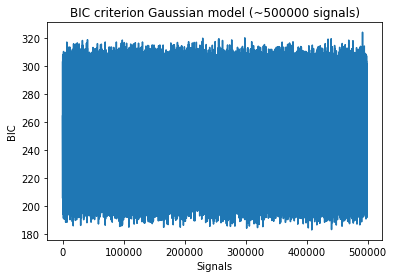

In [24]:
plt.plot(BICg)
plt.title('BIC criterion Gaussian model (~500000 signals)')
plt.xlabel('Signals')
plt.ylabel('BIC')

In [25]:
np.array(BICg).mean()

252.19413710940373

In [5]:
# def noise(x, offset):
#     return offset * np.ones(x.shape)
BICexp = []
rsdlexp = []
piks = []
rslt_evl = []
for i in range(len(amp)):
    from lmfit import Model, Parameters
    from lmfit.models import ExponentialGaussianModel
    b = amp[i] - amp[i][:3].mean()
    x = np.arange(len(b))
    initial_peak_x = x[np.argmax(b)]
    initial_peak_y = b[np.argmax(b)]
    model = ExponentialGaussianModel() # + Model(noise)
    model.set_param_hint('amplitude', value = int(initial_peak_y))
    model.set_param_hint('center', value = int(initial_peak_x))
    model.set_param_hint('sigma')
    model.set_param_hint('gamma')
    model.set_param_hint('offset', value = 0) # , min = ...
    param = model.make_params()
    reslt = model.fit(b, param, x = x, nan_policy = 'propagate')
    rvals = reslt.params.valuesdict()
    # print(rvals['offset'])
    time = np.arange(len(reslt.eval()))
    rsdlexp.append(reslt.residual)
    peaks = np.argmax(reslt.eval())
    rslt_evl.append(reslt.eval())
    piks.append(peaks)
    BICexp.append(reslt.bic)

In [6]:
mx = 0
for i in range(len(rsdlexp)):
    if len(rsdlexp[i]) > mx:
        mx = len(rsdlexp[i])

In [9]:
nan.shape

(100, 92)

In [8]:
nan = np.empty((len(rsdlexp), mx + (max(piks) - min(piks)) * 4))
nan[:] = np.nan
for i in range(len(rsdlexp)):
    if i == 0:
        nan[i, :][((max(piks) - min(piks)) * 2) : ((max(piks) - min(piks)) * 2 + len(rsdlexp[i]))] = rsdlexp[i]
        idx = piks[i] + (max(piks) - min(piks)) * 2
    else:
        pkf = abs(len(rsdlexp[i][:piks[i]]) - len(nan[i, :][:idx]))
        pkl = - abs(len(rsdlexp[i][piks[i]:]) - len(nan[i, :][idx:]))
        nan[i, :][pkf:idx] = rsdlexp[i][:piks[i]]
        nan[i, :][idx:pkl] = rsdlexp[i][piks[i]:]

In [10]:
mean = []
std = []
median = []
for i in range(nan.shape[1]):
    mn = np.nanmean(nan[:, i])
    st = np.nanstd(nan[:, i])
    md = np.nanmedian(nan[:, i])
    mean.append(mn), std.append(st), median.append(md)
mean = np.array(mean)
median = np.array(median)
std = np.array(std)
pkvl = std[idx]
mean = mean[~np.isnan(mean)]
median = median[~np.isnan(median)]
std = std[~np.isnan(std)]
idx_new = np.where(std == pkvl)[0][0]

/home/shaig93/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """
/home/shaig93/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/shaig93/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


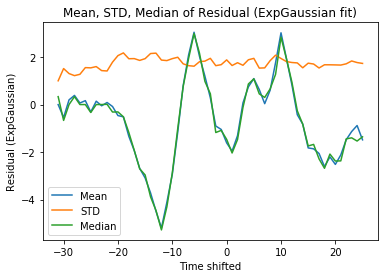

In [11]:
time = np.arange(len(mean))
plt.plot(time - idx_new, mean, label = 'Mean')
plt.plot(time - idx_new, std, label = 'STD')
plt.plot(time - idx_new, median, label = 'Median')
plt.title('Mean, STD, Median of Residual (ExpGaussian fit)')
plt.xlabel('Time shifted')
plt.ylabel('Residual (ExpGaussian)')
plt.legend()

Text(0.5, 1.0, 'BIC criterion ExpGaussian')

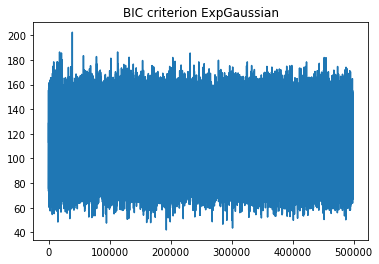

In [33]:
plt.plot(BICexp)
plt.title('BIC criterion ExpGaussian')

In [34]:
np.array(BICexp).mean()

111.34698976725608

Text(0, 0.5, 'Intensity')

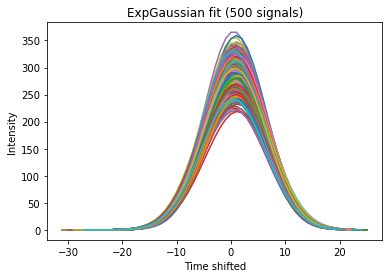

In [36]:
for i in range(500):
    time = np.arange(len(rslt_evl[:500][i]))
    plt.plot(time - np.argmax(rslt_evl[:500][i]), result_evl[:500][i])
plt.title('ExpGaussian fit (500 signals)')
plt.xlabel('Time shifted')
plt.ylabel('Intensity')

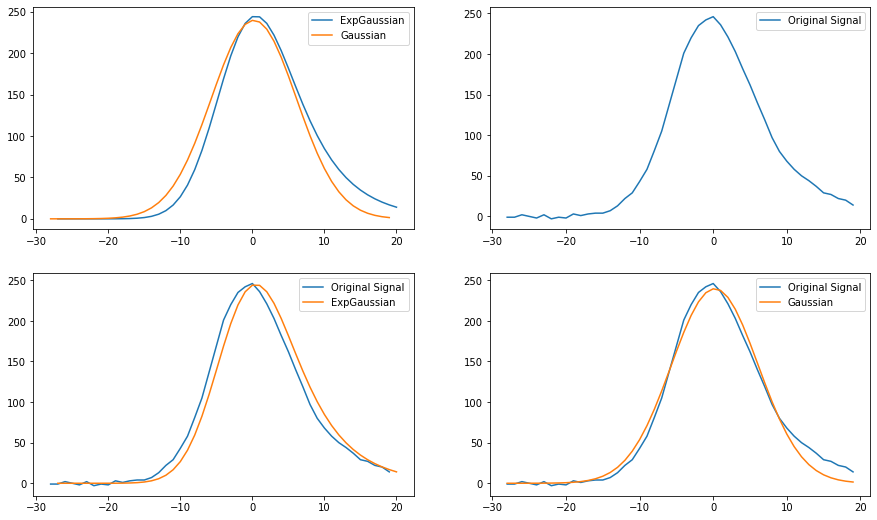

In [78]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize = (15, 9))
t = np.arange(len(rslt_evl[1]))
ax1[0].plot(t - np.argmax(rslt_evl[1]), rslt_evl[1], label = 'ExpGaussian')
ax1[0].plot(t - np.argmax(result_evl[1]), result_evl[1], label = 'Gaussian')
ax1[1].plot(t - np.argmax(amp[1]), amp[1] - amp[1][:3].mean(), label = 'Original Signal')
ax2[0].plot(t - np.argmax(amp[1]), amp[1] - amp[1][:3].mean(), label = 'Original Signal')
ax2[0].plot(t - np.argmax(rslt_evl[1]), rslt_evl[1], label = 'ExpGaussian')
ax2[1].plot(t - np.argmax(amp[1]), amp[1] - amp[1][:3].mean(), label = 'Original Signal')
ax2[1].plot(t - np.argmax(result_evl[1]), result_evl[1], label = 'Gaussian')
ax1[1].legend()
ax1[0].legend()
ax2[0].legend()
ax2[1].legend()
plt.show()